# **Karras Pre-Conditioning**

In [17]:
import os, timm, torch, random, datasets, math, fastcore.all as fc
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF, torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [2]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDIMScheduler, DDPMPipeline, DDPMScheduler

In [3]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 85

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## **Load and Prepare Data**

In [4]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
n_steps = 1000
bs = 512
dsd = load_dataset(name)

In [5]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)

dl = dls.train
xb, yb = b = next(iter(dl))

In [6]:
sig_data = 0.66

In [7]:
def scalings(sig):
    totvar = sig**2 + sig_data**2
    return sig_data**2 / totvar, sig*sig_data/totvar.sqrt(), 1/totvar.sqrt()

In [8]:
sig_samp = (torch.randn([10000])*1.2-1.2).exp()

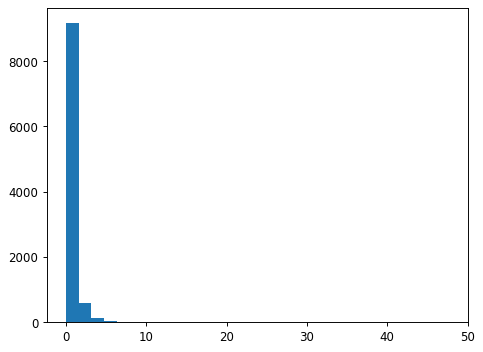

In [16]:
plt.hist(sig_samp, bins=30);

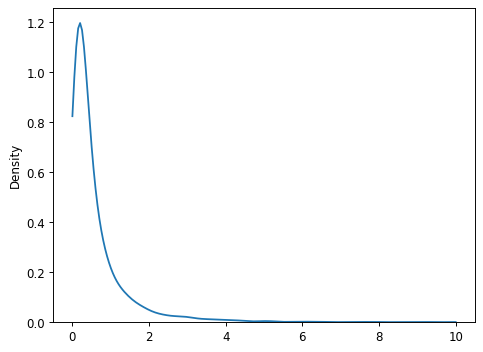

In [18]:
# Plotting the same using the KDE plot
sns.kdeplot(sig_samp, clip=(0, 10));

In [19]:
#
def noisify(x0):
    device = x0.device
    sig = (torch.randn([len(x0)])*1.2-1.2).exp().to(x0).reshape(-1,1,1,1)
    noise = torch.randn_like(x0, device=device)
    c_skip, c_out, c_in = scalings(sig)
    noised_input = x0 + noise*sig
    target = (x0-c_skip*noised_input)/c_out
    return (noised_input*c_in, sig.squeeze()), target

In [20]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=8)

In [21]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [22]:
dl = dls.train
(noised_input, sig), target = b = next(iter(dl))

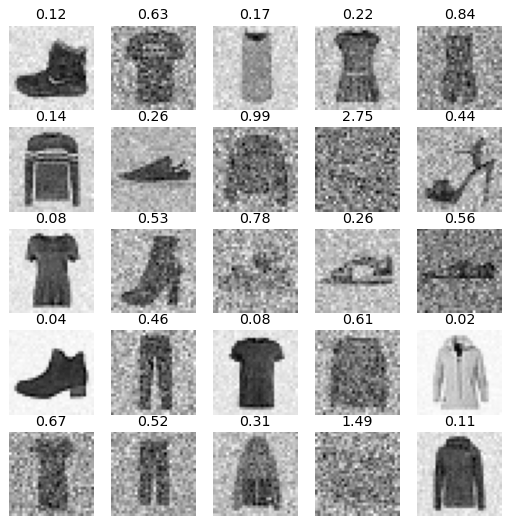

In [24]:
show_images(noised_input[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

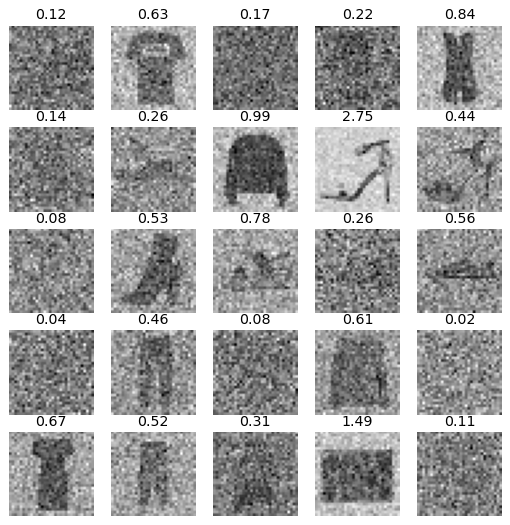

In [25]:
# Displaying the target images
show_images(target[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

In [26]:
noised_input.mean(), noised_input.std(), target.mean(), target.std()

(tensor(-0.68013), tensor(1.02185), tensor(-0.40704), tensor(1.03301))

## **Train Model**

In [27]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [28]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [29]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/fashion_karras.pkl')
# model = learn.model = torch.load('models/fashion_karras.pkl').cuda()

In [ ]:
def denoise(target, noised_input): return target*c_out + noised_input*c_skip 

In [ ]:
with torch.no_grad():
    sigr = sig.cuda().reshape(-1, 1, 1, 1)
    c_skip, c_out, c_in = scalings(sigr)
    targ_pred = learn.model((noised_input.cuda(), sig.cuda()))
    x0_pred = denoise(targ_pred, noised_input.cuda() / c_in)

In [ ]:
show_images(noised_input[:25], imsize=1.8, titles=fc.map_ex(sig[:25], '{:.02f}'))

In [ ]:
show_images(x0_pred[:25].clamp(-1,1), imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

In [ ]:
show_images(denoise(target.cuda(), noised_input.cuda()/c_in)[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

In [ ]:
sig_r = tensor(80.).cuda().reshape(-1, 1, 1, 1)
c_skip, c_out, c_in = scalings(sig_r)
x_r = torch.randn(32, 1, 32, 32).to(model.device)*sig_r

with torch.no_grad():
    targ_pred = learn.model((x_r*c_in, sig_r.squeeze()))
    x0_pred = denoise(targ_pred, x_r)

show_images(x0_pred[:25], imsize=1.8)

In [ ]:
x0_pred.max(), x0_pred.min(), x0_pred.mean(), x0_pred.std()

## **Sampling**